In [11]:
import sys
import os

MI_DIR="/Users/charliexiao/CLionProjects/mitsuba3/build/release"

sys.path.insert(0,os.path.join(MI_DIR,"python"))
os.environ['PATH'] = MI_DIR+":"+os.environ['PATH']

In [12]:
import mitsuba as mi
import drjit as dr

mi.set_variant('llvm_rgb')

In [3]:
scene = mi.load_dict(mi.cornell_box())

In [4]:
img = mi.render(scene)
mi.util.convert_to_bitmap(img)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

In [5]:
[ name for name in dir(mi) if "Integrator" in name]

['AdjointIntegrator',
 'CppADIntegrator',
 'Integrator',
 'MonteCarloIntegrator',
 'SamplingIntegrator']

In [6]:
from typing import Tuple,List

class AmbientIntegrator(mi.SamplingIntegrator):
  def __init__(self,props:mi.Properties) -> None:
    super().__init__(props)
  
  def sample(self, 
             scene:mi.Scene, 
             sampler:mi.Sampler, 
             ray:mi.RayDifferential3f, 
             medium:mi.Medium = None, 
             active:mi.Mask = True) -> Tuple[mi.Spectrum,mi.Mask,List[mi.Float]]:
    # using PyReturn = std::tuple<Spectrum, Mask, std::vector<Float>>;
    # the result value must be like this         
    pi:mi.PreliminaryIntersection3f = scene.ray_intersect_preliminary(ray,True,active)
    # the return value must be Tuple[mi.Spectrum,mi.Mask,List[mi.Float]]
    return (dr.select(pi.is_valid(),pi.t,0.0),pi.is_valid(),[])
  
mi.register_integrator("ao", lambda props: AmbientIntegrator(props))

In [7]:
ao_integrator = mi.load_dict({
  'type':'ao'
})
img = mi.render(scene,integrator=ao_integrator)
bitmap:mi.Bitmap = mi.Bitmap(img)
bitmap.write("cbox-depth.exr")

In [71]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  -----------------------------------------------------------------------------------
  Name                            Flags    Type            Parent
  -----------------------------------------------------------------------------------
  back.to_world                            Transform4f     Rectangle
  back.bsdf.reflectance.value     ∂        Color3f         SRGBReflectanceSpectrum
  ceiling.to_world                         Transform4f     Rectangle
  floor.to_world                           Transform4f     Rectangle
  green.reflectance.value         ∂        Color3f         SRGBReflectanceSpectrum
  green-wall.to_world                      Transform4f     Rectangle
  large-box.vertex_count                   int             Cube
  large-box.face_count                     int             Cube
  large-box.faces                          UInt            Cube
  large-box.vertex_positions      ∂, D     Float           Cube
  large-box.vertex_normals        ∂, D     Floa

In [8]:
mi.cornell_box()

{'type': 'scene',
 'integrator': {'type': 'path', 'max_depth': 8},
 'sensor': {'type': 'perspective',
  'fov_axis': 'smaller',
  'near_clip': 0.001,
  'far_clip': 100.0,
  'focus_distance': 1000,
  'fov': 39.3077,
  'to_world': [[-1, 0, 0, 0],
   [0, 1, 0, 0],
   [0, 0, -1, 3.9],
   [0, 0, 0, 1]],
  'sampler': {'type': 'independent', 'sample_count': 64},
  'film': {'type': 'hdrfilm',
   'width': 256,
   'height': 256,
   'rfilter': {'type': 'gaussian'},
   'pixel_format': 'rgb',
   'component_format': 'float32'}},
 'white': {'type': 'diffuse',
  'reflectance': {'type': 'rgb', 'value': [0.885809, 0.698859, 0.666422]}},
 'green': {'type': 'diffuse',
  'reflectance': {'type': 'rgb', 'value': [0.105421, 0.37798, 0.076425]}},
 'red': {'type': 'diffuse',
  'reflectance': {'type': 'rgb', 'value': [0.570068, 0.0430135, 0.0443706]}},
 'light': {'type': 'rectangle',
  'to_world': [[0.23, 0, 0, 0],
   [0, -8.30516e-09, -0.19, 0.99],
   [0, 0.19, -8.30516e-09, 0.01],
   [0, 0, 0, 1]],
  'bsdf': {'

In [17]:
%matplotlib inline

[0.70710677 0.         0.70710677]
(800, 3)
(800, 1)


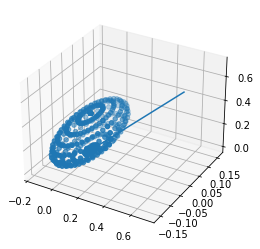

In [26]:
import numpy as np
import matplotlib.pyplot as plt

theta_in = np.radians(45)
phi_in = 0

diffuse_bsdf = mi.load_dict({
  'type':'diffuse',
  'reflectance':{
    'type':'rgb',
    'value':[0.5,0.5,0.5]
  }
})

def sph_to_dir(theta, phi):
    """Map spherical to Euclidean coordinates"""
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

# Create a (dummy) surface interaction to use for the evaluation of the BSDF
si = dr.zeros(mi.SurfaceInteraction3f)

# Specify an incident direction with 45 degrees elevation
si.wi = sph_to_dir(theta_in,phi_in)

# Create grid in spherical coordinates and map it onto the sphere
res = 20
theta_o, phi_o = dr.meshgrid(
    dr.linspace(mi.Float, 0,     dr.pi,     res),
    dr.linspace(mi.Float, 0, 2 * dr.pi, 2 * res)
)
wo = sph_to_dir(theta_o, phi_o)

# Evaluate the whole array (18000 directions) at once
pdf = diffuse_bsdf.pdf(mi.BSDFContext(), si, wo)

np_wi = np.array(si.wi).flatten()
print(np_wi)

np_dir = np.array(wo) 
print(np_dir.shape)

np_pdf = np.array(pdf).reshape((-1,1))
print(np_pdf.shape)

points = np_dir * np_pdf

# value f in direction wo


plt.figure()
ax = plt.axes([0.1,0.1,0.8,0.8],projection='3d')

# print(type(ax))

# # axis settings
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
# ax.set_zlim(-1.5,1.5)

# # drawing...
# # ax.scatter(d[0],d[1],d[2])
ax.plot([0,np_wi[0]],[0,np_wi[1]],[0,np_wi[2]])
ax.scatter(points[:,0],points[:,1],points[:,2])

In [27]:
dir(plt.cm)

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'ColormapRegistry',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'Mapping',
 'MutableMapping',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'ScalarMappable',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 '_DeprecatedCmapDictWrapper',
 '_LUTSIZE',
 '__builtin_cmaps',
 '__builtins__',
 '__cached__',
 '__doc__',

In [ ]:
mi.Frame3f.cos_theta